# kNN+gzip is all you need?! 

A week ago or so I heard about this “Low-Resource” Text Classification: A Parameter-Free Classification
Method with Compressors paper (https://aclanthology.org/2023.findings-acl.426.pdf), where they claimed to beat BeRT on sentiment analysis classification. 

Once in a while, I see something and I am just compelled to try for myself, and this was one of those times. 

It has everything, it’s simple, it’s fast, it’s easy to implement, and it's my favorite machine learning algorithm, k Nearest Neighbors. I sometimes do contracting and consulting for clients, and the number of times that I've told someone that their problem doesn't need deep learning and can instead be done easier, cheaper and just as effectively, with a kNN approach, is too many to count. So, when I see something super simple like this, doing text classification for sentiment analysis with kNN for the classification and gzip with "compression distances" being used as the feature vectors, I just have to try it for myself.

The research paper came with code on github: https://github.com/bazingagin/npc_gzip, but it comes with a bunch of extra tweaks and techniques for getting the most performance, but I want something super simple and clear. I just wanted to confirm that I had a grasp on how this actually works, because this idea of compressed distances sounds simple but also a bit strange, so if you're a little fuzzy on what the heck this is, no worries because we're going to be "from scratch-ing" it here, though you should already know what k Nearest Neighbors is. I have an older tutorial on it where I built everything from scratch, if you do not know what kNN is, you can check that out here: https://pythonprogramming.net/k-nearest-neighbors-application-machine-learning-tutorial/

# Gzip method

In [43]:
import pickle

# load data
with open(f"sentiment-dataset-{N_SAMPLES}.pickle", "rb") as f:
    dataset = pickle.load(f)

train_x, train_y, test_x, test_y = dataset # samples are text strings (x) and sentiment -1 or 1 (y)

In [44]:
%%time
import gzip
from sklearn.neighbors import KNeighborsClassifier

N_SAMPLES = 500 

def ncd(x, x2): # NCD with compressed lengths
    x_compressed = len(gzip.compress(x.encode()))
    x2_compressed = len(gzip.compress(x2.encode()))  
    xx2 = len(gzip.compress((" ".join([x,x2])).encode()))
    return (xx2 - min(x_compressed, x2_compressed)) / max(x_compressed, x2_compressed)

train_ncd = [[ncd(train_x[i], train_x[j]) for j in range(len(train_x))] for i in range(len(train_x))]
test_ncd = [[ncd(test_x[i], train_x[j]) for j in range(len(train_x))] for i in range(len(test_x))]

# KNN classification
neigh = KNeighborsClassifier(n_neighbors=7) 
neigh.fit(train_ncd, train_y)
print("Accuracy:", neigh.score(test_ncd, test_y))

Accuracy: 0.7029702970297029
CPU times: user 27 s, sys: 8.96 ms, total: 27 s
Wall time: 27.1 s


# Traditional TF-IDF + Logistic regression
from https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html

In [42]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Extracting features from the training data using a sparse vectorizer
vectorizer = TfidfVectorizer(
    sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
)
X_train = vectorizer.fit_transform(train_x)
X_test = vectorizer.transform(test_x)
feature_names = vectorizer.get_feature_names_out()

clf = LogisticRegression(C=5, max_iter=1000)
clf.fit(X_train, train_y)
# pred = clf.predict(X_test)

# score = metrics.accuracy_score(test_y, pred)
print("Accuracy:", clf.score(X_test, test_y))

Accuracy: 0.8613861386138614
CPU times: user 108 ms, sys: 2.87 ms, total: 111 ms
Wall time: 111 ms


# Compare positive and negative posts

In [45]:
positive_posts = [train_x[i] for i in range(len(train_x)) if train_y[i] == 1]
negative_posts = [train_x[i] for i in range(len(train_x)) if train_y[i] == -1]

## Compare sentence lengths

Question: Do positive posts tend to be longer than negative posts?

In [49]:
# compare average length
print("Average length of positive posts (in characters):", sum([len(post) for post in positive_posts]) / len(positive_posts))
print("Average length of negative posts (in characters):", sum([len(post) for post in negative_posts]) / len(negative_posts))

Average length of positive posts (in characters): 1284.4947368421053
Average length of negative posts (in characters): 1170.2843601895734


On average, the positive posts are 100 characters longer than the negative posts. Lets now see the distribution of the lengths of the posts.

Text(0, 0.5, 'Frequency')

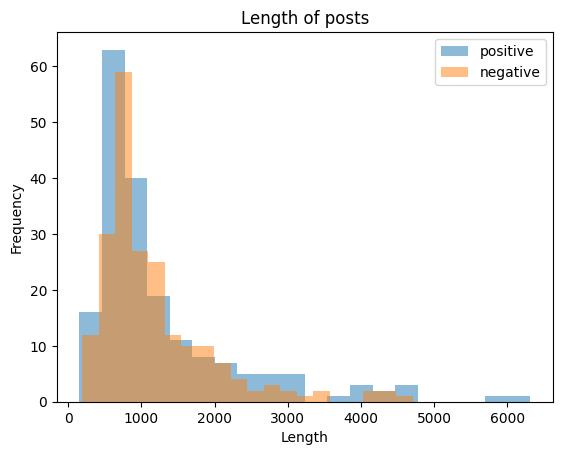

In [78]:
import matplotlib.pyplot as plt
plt.hist([len(post) for post in positive_posts], bins=20, alpha=0.5, label="positive")
plt.hist([len(post) for post in negative_posts], bins=20, alpha=0.5, label="negative")
plt.legend()
plt.title("Length of posts")
plt.xlabel("Length")
plt.ylabel("Frequency")

We see that the majority of posts are between 0 and 2000 characters and that the distribution is similar for both positive and negative posts.

Conclusion: Positive and negative posts have similar lengths.

## Compare compressed lengths

Are the compressed lengths of the positive posts longer than the negative posts?

In [57]:
compressed_x = [gzip.compress(post.encode()) for post in train_x]

In [60]:
positive_compressed = [compressed_x[i] for i in range(len(compressed_x)) if train_y[i] == 1]
negative_compressed = [compressed_x[i] for i in range(len(compressed_x)) if train_y[i] == -1]

In [61]:
# compare average length
print("Average compressed length of positive posts (in characters):", sum([len(post) for post in positive_compressed]) / len(positive_compressed))
print("Average compressed length of negative posts (in characters):", sum([len(post) for post in negative_compressed]) / len(negative_compressed))

Average compressed length of positive posts (in characters): 695.5578947368421
Average compressed length of negative posts (in characters): 644.8815165876778


Text(0, 0.5, 'Frequency')

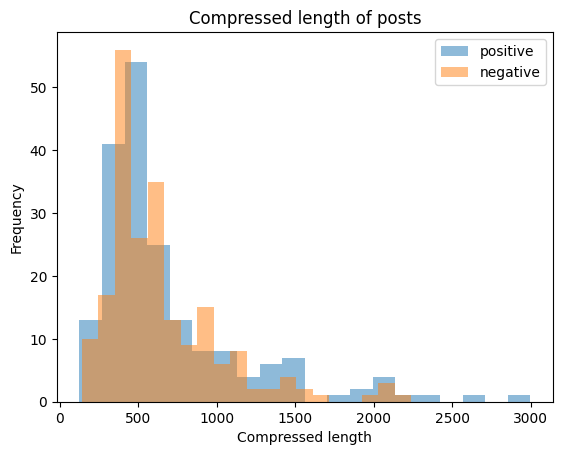

In [77]:
import matplotlib.pyplot as plt
plt.hist([len(post) for post in positive_compressed], bins=20, alpha=0.5, label="positive")
plt.hist([len(post) for post in negative_compressed], bins=20, alpha=0.5, label="negative")
plt.legend()
plt.title("Compressed length of posts")
plt.xlabel("Compressed length")
plt.ylabel("Frequency")

Here, we again see that the compressed length is not a good predictor of the sentiment of the post.

## Compare the compression ratios

Question: Do the negative posts contain more "information" than the positive posts?

In [66]:
ratios_x = [len(post) / len(gzip.compress(post.encode())) for post in train_x]

In [67]:
positive_ratios = [ratios_x[i] for i in range(len(ratios_x)) if train_y[i] == 1]
negative_ratios = [ratios_x[i] for i in range(len(ratios_x)) if train_y[i] == -1]

In [75]:
# compare average length
print("Average compressed length of positive posts (in characters):", np.mean(positive_ratios))
print("Average compressed length of negative posts (in characters):", np.mean(negative_ratios))

Average compressed length of positive posts (in characters): 1.7459377611633093
Average compressed length of negative posts (in characters): 1.736048784924558


Text(0, 0.5, 'Frequency')

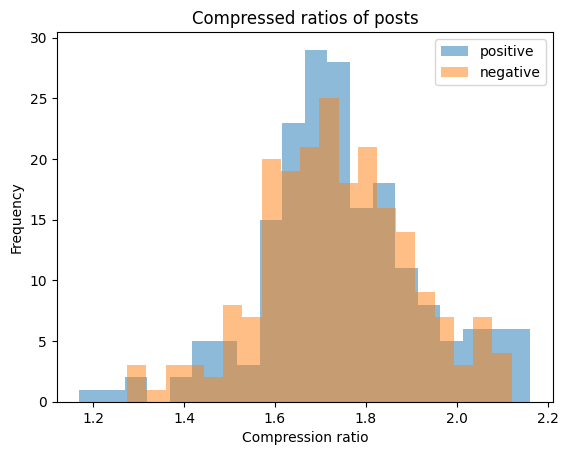

In [76]:
import matplotlib.pyplot as plt
plt.hist(positive_ratios, bins=20, alpha=0.5, label="positive")
plt.hist(negative_ratios, bins=20, alpha=0.5, label="negative")
plt.legend()
plt.title("Compressed ratios of posts")
plt.xlabel("Compression ratio")
plt.ylabel("Frequency")

Here, we again see that the compression ratio is not a good predictor of the sentiment of the post. The compression ratio is similar for both positive and negative posts.